In [ ]:
# in this python workbook, I will do the below

# EDA - with helper functions
# dendrogram to see correlation on columns
# Partial Dependence plots to see interactions of features in model
# Model tuning - lasso vs elastic net - using RandomSearchCV (speed) then GridsearchCv (extensive search)
# feature selection with Hypothesis testing (SelectKBest) with f_regression and mutual info regression, feature importances from RF (SelectFromModel)
# residual plots
# feature engineering with polynomial features
# feature selection...again..this time with Boruta (performs worse than other methods)
# final residual plot


In [245]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from rfpimp import feature_corr_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,RandomizedSearchCV
)
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [315]:
# plot functions

def df_datatypes(dataframe):
    print(dataframe.columns.to_series().groupby(dataframe.dtypes).groups)
    
def missing(dataframe, graph=False):
    dataframe_na = (dataframe.isnull().sum() / len(dataframe)) * 100
    dataframe_na = dataframe_na.drop(dataframe_na[dataframe_na == 0].index).sort_values(
        ascending=False
    )[:30]
    missing_data = pd.DataFrame({"Missing Ratio": dataframe_na})
    print(missing_data.head(20))
    if graph == True:
        missing_data = dataframe.columns[dataframe.isnull().any()].tolist()
        msno.matrix(dataframe[missing_data])
        msno.heatmap(dataframe[missing_data], figsize=(20, 20))

def cardinality(dataframe, datatype):
    d = []
    columns = dataframe.dtypes[dataframe.dtypes == datatype].index
    # columns = dataframe.columns.tolist()
    for c in columns:
        data = dataframe[c].nunique()
        d.append({"Column": c, "UniqueValue": data})
    df = pd.DataFrame(d).sort_values(ascending=False, by="UniqueValue")
    print(df)

def define_vars(dataframe, card_thresh):
    dtypes = dataframe.dtypes
    cat_feats = dataframe.dtypes[dataframe.dtypes == "object"].index
    numeric_feats = dataframe.dtypes[dataframe.dtypes != "object"].index
    col_nunique = dict()
    for col in numeric_feats:
        col_nunique[col] = dataframe[col].nunique()
    col_nunique = pd.Series(col_nunique)
    cols_discrete = col_nunique[col_nunique < card_thresh].index.tolist()
    cols_continuous = col_nunique[col_nunique >= card_thresh].index.tolist()
    return cols_discrete, cols_continuous, cat_feats

def PlotCont(dataframe, columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3 * fcols, 4 * frows))
    i = 0
    for col in columns:
        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(dataframe[col], ax=ax)
    plt.xlabel(col)
    
def PlotCat(dataframe, cat_feats, fcols=3):
    fcols = fcols
    frows = ceil(len(cat_feats) / fcols)
    plt.figure(figsize=(20, frows * 4))

    for i, col in enumerate(cat_feats):
        plt.subplot(frows, fcols, i + 1)
        sns.countplot(dataframe[col])
        

def PlotCatRegress(dataframe,target,cat_feats,fcols=3):
    fcols = 3
    frows = ceil(len(cat_feats)/fcols)
    plt.figure(figsize = (20,frows*4))
    
    for i,col in enumerate(cat_feats):
        plt.subplot(frows,fcols,i+1)
        sns.violinplot(dataframe[col],dataframe[target],inner="stick")

# plots all continuous variables vs target


def PlotContRegress(dataframe,target,columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3*fcols,4*frows))
    i=0
    for col in columns:
        i+=1
        ax=plt.subplot(frows,fcols,i)
        sns.regplot(x=col,y=target,data=dataframe,ax=ax)
    plt.xlabel(col)

def pear_corr(dataframe):
    df_corr_mat = feature_corr_matrix(dataframe)
    df_corr_mat = df_corr_mat.dropna(axis='columns',how='all')
    df_corr_mat = df_corr_mat.dropna()
    df_corr_mat = df_corr_mat.values
    corr_condensed = hc.distance.squareform(1-df_corr_mat)
    z = hc.linkage(corr_condensed,method='average')
    fig = plt.figure(figsize=(20,10))
    dendrogram = hc.dendrogram(z,labels=dataframe.columns,orientation = 'left',leaf_font_size = 8)


def residual_plot(model,X,y):
    
    y_pred = model.predict(X)
    y_pred = pd.Series(y_pred,index=y_train.index)
    resid = y_train - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    outliers = z[abs(z)>3].index
    print(len(outliers),'outliers:')
    print(outliers.tolist())
    
    resid = resid.sort_values(ascending=False)
    resid_top_5 = resid[:5]
    resid_bottom_5 = resid[-5:]
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.ylim(top =4)
    plt.ylim(bottom=1.5)
    plt.xlim(right=4)
    plt.xlim(left=1.5)
    plt.plot(y_train,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.ylim(top=1)
    plt.ylim(bottom=-1)
    for i in resid_top_5.index:
       ax_132.annotate(i, xy=(y[i],resid[i]))
    for i in resid_bottom_5.index:
       ax_132.annotate(i, xy=(y[i],resid[i]))
    plt.plot(y_train,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

In [329]:
# read data and look at datatypes

url = 'https://github.com/GinoWoz1/Learnings/raw/master/'

boston_input = pd.read_csv(url+'boston.csv')
boston_input.columns = [x.lower() for x in boston_input.columns]

# garbage column- made groupings in tableau and fed the data in

boston_input.drop(['number of records'],axis=1,inplace=True)

df_datatypes(boston_input)


{dtype('int64'): Index(['chas', 'rad', 'tax'], dtype='object'), dtype('float64'): Index(['age', 'crim', 'dis', 'indus', 'lstat', 'mv', 'nox', 'ptratio', 'rooms',
       'zn'],
      dtype='object'), dtype('O'): Index(['neighborhood (group)', 'neighborhood'], dtype='object')}


In [330]:
# see if any missing data, none
missing(boston_input)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [332]:
# check cardinality of int

print(cardinality(boston_input,datatype= 'int64'))
print(cardinality(boston_input,datatype= 'float64'))
print(cardinality(boston_input,datatype= 'object'))

# no discrete variables for numerical variables, will just define continuous and cat

discrete,cont,cat = define_vars(boston_input,1) # no discrete 1
print(discrete)
print(cont)
print(cat)

  Column  UniqueValue
2    tax           66
1    rad            9
0   chas            2
None
    Column  UniqueValue
1     crim          504
4    lstat          455
8    rooms          446
2      dis          412
0      age          356
5       mv          228
6      nox           81
3    indus           76
7  ptratio           46
9       zn           26
None
                 Column  UniqueValue
1          neighborhood           93
0  neighborhood (group)            7
None
[]
['age', 'chas', 'crim', 'dis', 'indus', 'lstat', 'mv', 'nox', 'ptratio', 'rad', 'rooms', 'tax', 'zn']
Index(['neighborhood (group)', 'neighborhood'], dtype='object')


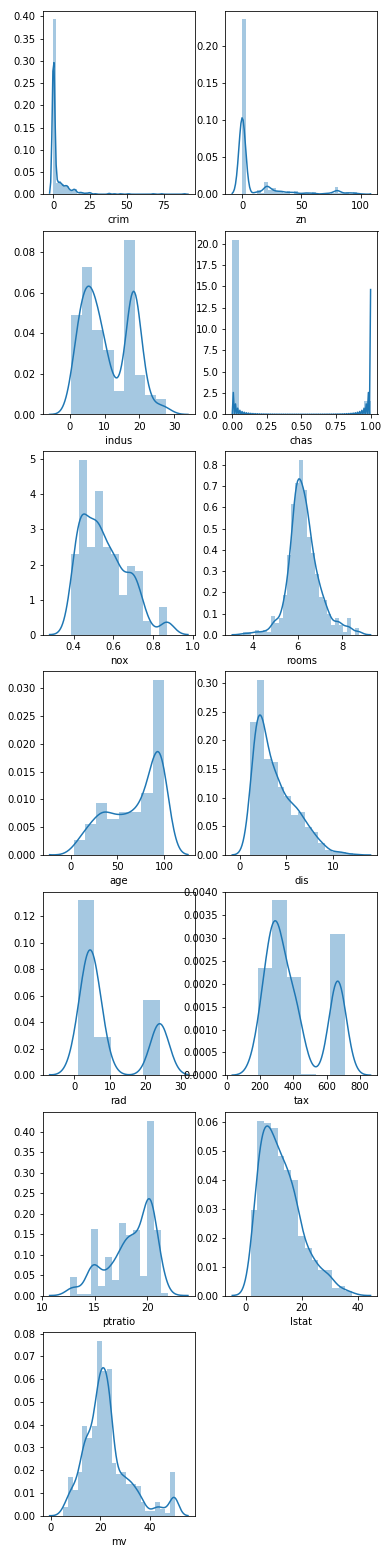

In [250]:
PlotCont(boston_input,cont)

# do eda on numeric variables, mostly continuous 

# mv - median values of homes (target)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


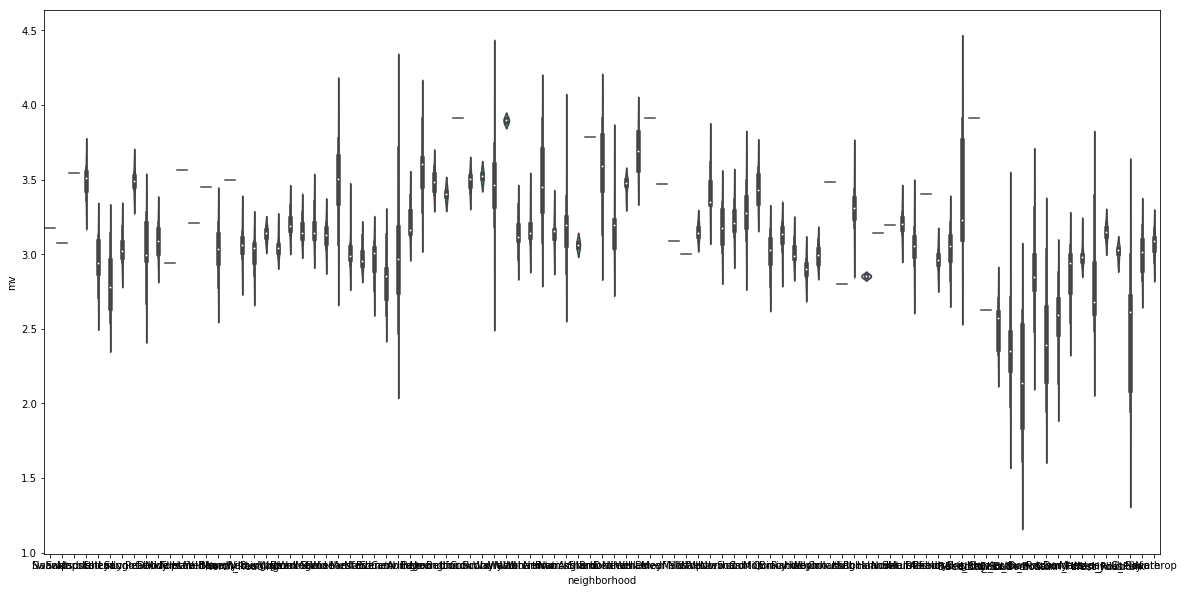

In [339]:
# look at values

plt.figure(figsize=(20,10))
sns.violinplot(x=boston_input.neighborhood,y=np.log(boston_input.mv))

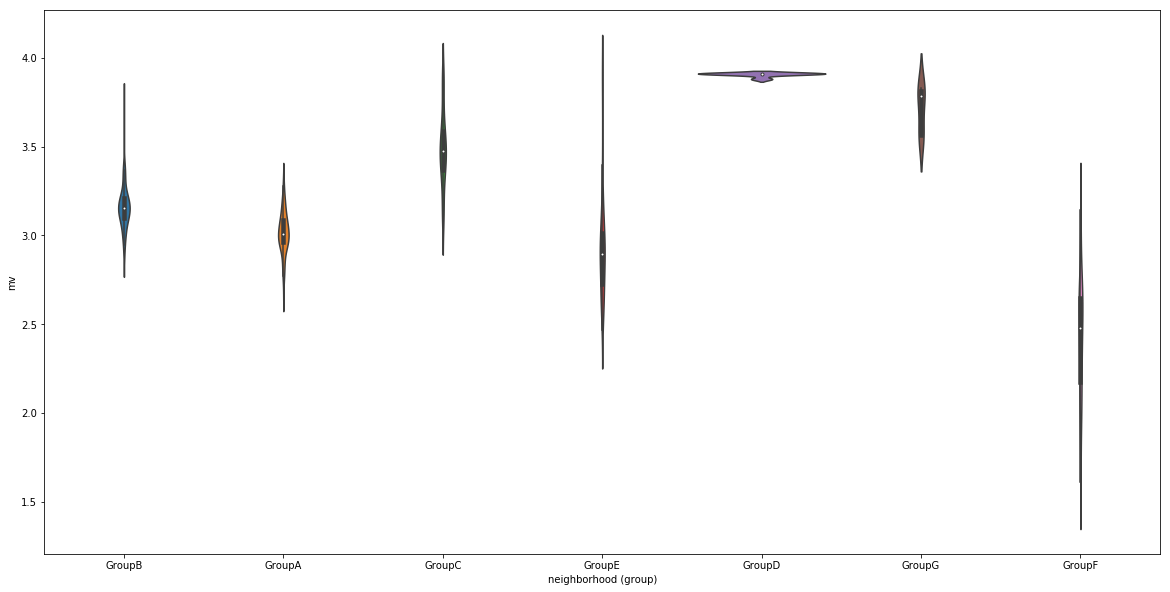

In [340]:
# in tableau, I manually grouped these to larger groups

plt.figure(figsize=(20,10))
sns.violinplot(x=boston_input['neighborhood (group)'],y=np.log(boston_input.mv))


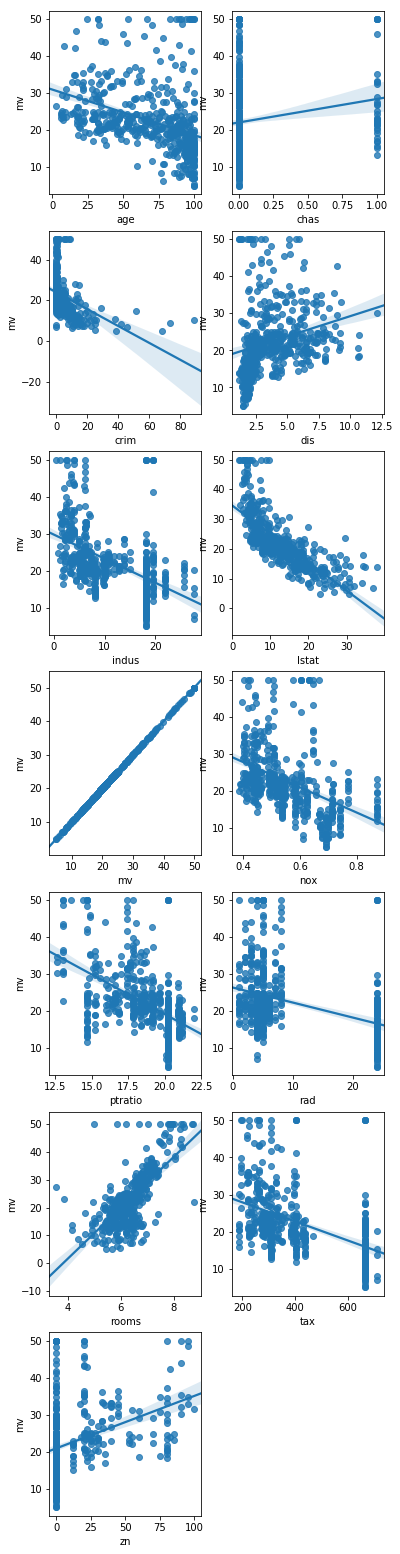

In [341]:
PlotContRegress(boston_input,'mv',cont)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


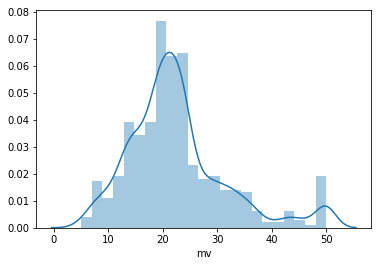

In [342]:
sns.distplot(boston_input.mv)

In [343]:
# transform the y variable using log
# drop neighborhood (too sparse), using group neighborhood

X = boston_input.drop(['mv','neighborhood'],axis=1)
y = np.log(boston_input.mv)

print(X.head(5))

  neighborhood (group)         age  chas       crim        dis      indus  \
0               GroupB 65.20000000     0 0.00632000 4.09000000 2.31000000   
1               GroupA 78.90000000     0 0.02731000 4.96710000 7.07000000   
2               GroupC 61.10000000     0 0.02729000 4.96710000 7.07000000   
3               GroupC 45.80000000     0 0.03237000 6.06220000 2.18000000   
4               GroupC 54.20000000     0 0.06905000 6.06220000 2.18000000   

       lstat        nox     ptratio  rad      rooms  tax          zn  
0 4.98000000 0.53800000 15.30000000    1 6.57500000  296 18.00000000  
1 9.14000000 0.46900000 17.80000000    2 6.42100000  242  0.00000000  
2 4.03000000 0.46900000 17.80000000    2 7.18500000  242  0.00000000  
3 2.94000000 0.45800000 18.70000000    3 6.99800000  222  0.00000000  
4 5.33000000 0.45800000 18.70000000    3 7.14700000  222  0.00000000  


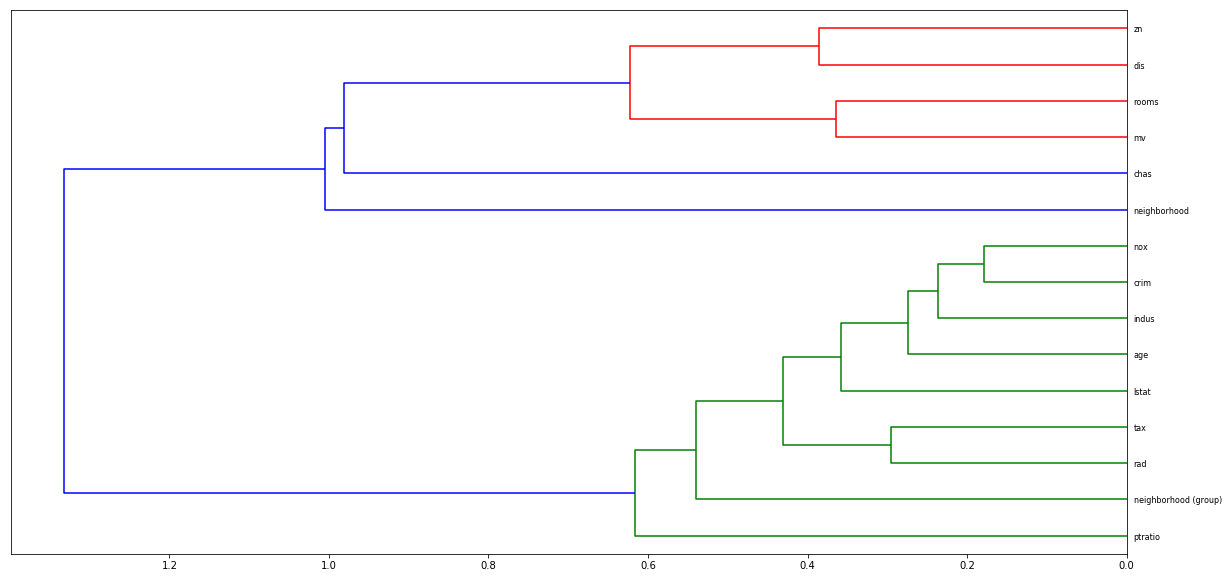

In [344]:
from scipy.cluster import hierarchy as hc
from rfpimp import feature_corr_matrix
pear_corr(boston_input)

In [345]:
# import modelling components and then use pdp to analyze highly correlated variables and potential interactions

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,PolynomialFeatures
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedKFold,train_test_split
from sklearn.pipeline import Pipeline

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.6,random_state=5)

X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

# check to see if test set is representative of train ( for generalization)
print(X_train.describe().T)
print(X_test.describe().T)


                                   count         mean          std  \
age                         303.00000000  66.79273927  28.86912946   
chas                        303.00000000   0.05610561   0.23050624   
crim                        303.00000000   3.66021099   8.76304629   
dis                         303.00000000   3.80061452   2.05930043   
indus                       303.00000000  10.94825083   6.70117791   
lstat                       303.00000000  12.64141914   7.19371992   
nox                         303.00000000   0.55207261   0.11491461   
ptratio                     303.00000000  18.51683168   2.16946308   
rad                         303.00000000   9.61056106   8.74170301   
rooms                       303.00000000   6.29269307   0.69407759   
tax                         303.00000000 404.79537954 169.27972964   
zn                          303.00000000  11.72442244  23.23218104   
neighborhood (group)_GroupB 303.00000000   0.21782178   0.41344844   
neighborhood (group)

In [346]:
# define cv for randomized search cv with random forest

# this will be used to look at the partial dependence plots

from sklearn.metrics import make_scorer, mean_squared_error

def rmse_cv(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    if not (y_true >= 0).all() and not (y_pred >= 0).all():
        raise ValueError("Mean Squared Logarithmic Error cannot be used when "
                         "targets contain negative values.")
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
    return np.sqrt(mean_squared_error(y_true,y_pred))

rmse_cv = make_scorer(rmse_cv,greater_is_better=False)

rkfold = RepeatedKFold(n_splits=5,n_repeats=5)

rf = RandomForestRegressor()

rf_param = {'max_depth':[3,5,7],
           'min_samples_split':range(2,7,1),
           'max_features':[0.3,0.4,0.5,0.6],
           'n_estimators':range(50,100,10)}

rs = RandomizedSearchCV(rf,param_distributions= rf_param,scoring=rmse_cv,cv=rkfold,n_iter=50)
rs.fit(X_train,y_train)
print(rs.best_score_)
print(rs.best_estimator_)
print(rs.score(X_test,y_test))

-3.5486585745011103
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-3.431523219909519


In [347]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=True)
rf.fit(X_train,y_train)
rf.oob_score_

from pdpbox import pdp

def plot_pdp(feat,clusters=None,feat_name=None):
    feat_name = feat_name or feat 
    p = pdp.pdp_isolate(rf,model_features= X_train.columns.tolist(),dataset=X_train,feature = feat) 
    return pdp.pdp_plot(p,feat_name,plot_lines=True, 
                        cluster=clusters, n_cluster_centers=clusters,plot_pts_dist=True)


(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423eaab400>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423b328e80>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423ebbb208>}})

<Figure size 432x288 with 0 Axes>

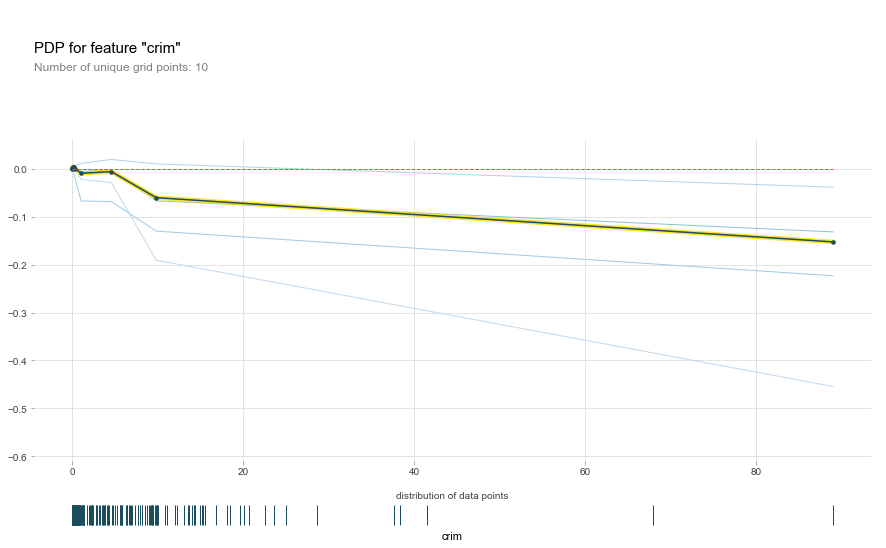

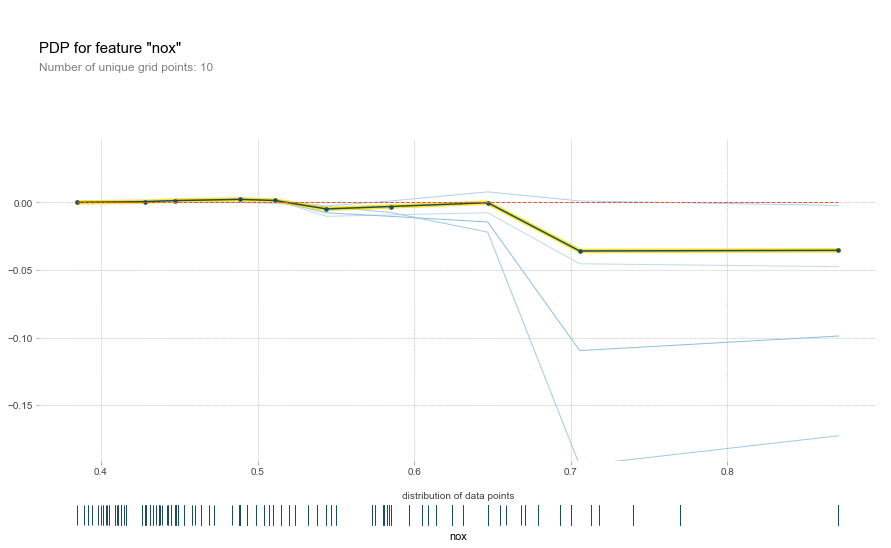

In [348]:
# plot crime and nox
# pdps take a already fit model and compare the dependence of the model vs the variable
# pdps assume independence of variables which is hard to maintain at times - especially since nox and crime are correlated

# crim has a big effect after a certain point, I didn't do it here but I may try to do feature engineering in
# the future on crime by creating boolean features
# nox is the same

plt.figure(1)
plot_pdp('crim',clusters=4)
plt.figure(2)
plot_pdp('nox',clusters=4)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x24235d20eb8>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x24235dca7b8>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x24235df2a58>}})

<Figure size 432x288 with 0 Axes>

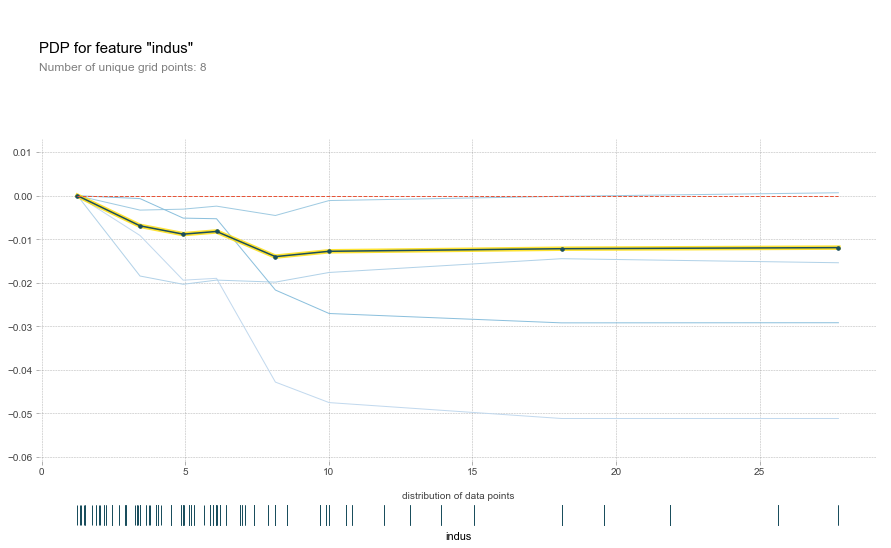

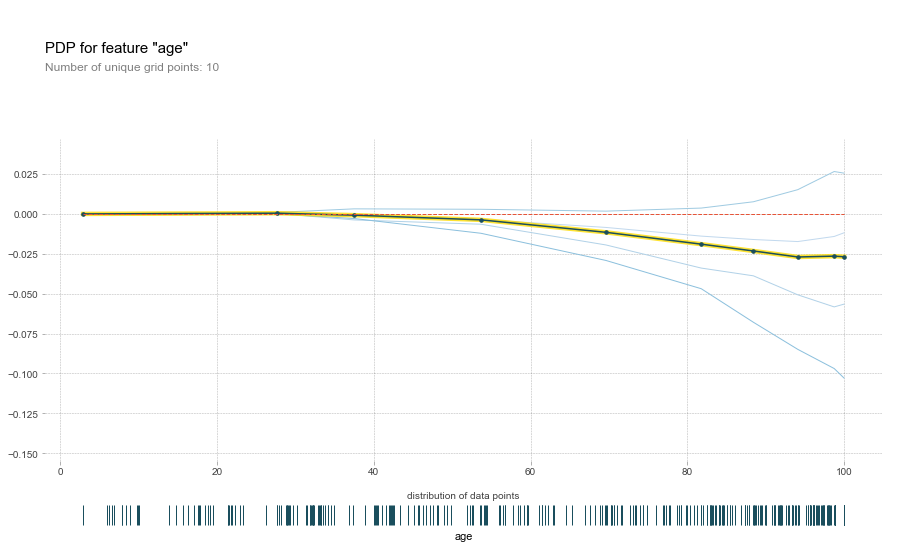

In [349]:
# plot industrial (%) and age
# nothing interesting for industry
# age has a biggest effect at the higher number range

plt.figure(1)
plot_pdp('indus',4)
plt.figure(2)
plot_pdp('age',4)

In [350]:
# nothing done with the above but just interested to see the independent effects of the variables
# run elastic net first using standard scaler

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('std_scaler',StandardScaler()),
              ('elnet',elnet)])

rs2 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=50)

rs2.fit(X_train,y_train)
print(rs2.best_score_)
print(rs2.best_estimator_)
print(rs2.score(X_test,y_test))



-3.897657909222071
Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.01, warm_start=False))])
-4.528437716052726


In [351]:
# run with minmax scaler

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('min_scaler',MinMaxScaler()),
              ('elnet',elnet)])

rs3 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=50)

rs3.fit(X_train,y_train)
print(rs3.best_score_)
print(rs3.best_estimator_)
print(rs3.score(X_test,y_test))

-5.867627403290084
Pipeline(memory=None,
     steps=[('min_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.01, warm_start=False))])
-7.140610135077647


In [352]:
# run with max abs scaler

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('max_scaler',MaxAbsScaler()),
              ('elnet',elnet)])

rs4 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=50)

rs4.fit(X_train,y_train)
print(rs4.best_score_)
print(rs4.best_estimator_)
print(rs4.score(X_test,y_test))

-7.1952006435762845
Pipeline(memory=None,
     steps=[('max_scaler', MaxAbsScaler(copy=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.4,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False))])
-8.14671759053478


In [353]:
# lasso with standard scaler

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('std_scaler',StandardScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-5.717061132843816
Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-6.323298694774875


In [354]:
# lasso with minmax scaler

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('min_scaler',MinMaxScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-9.019177557973213
Pipeline(memory=None,
     steps=[('min_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-9.68802065425981


In [355]:
# lasso with maxabs

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('max_scaler',MaxAbsScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmse_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-8.9962925559263
Pipeline(memory=None,
     steps=[('max_scaler', MaxAbsScaler(copy=True)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-9.68802065425981


{'elnet__tol': 0.01, 'elnet__l1_ratio': 0.1, 'elnet__alpha': 0.1}
9 outliers:
[166, 401, 416, 374, 391, 364, 369, 399, 400]


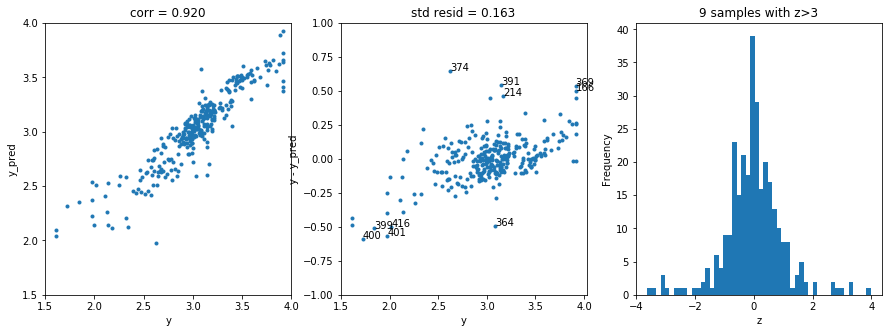

In [356]:
# visualize best model residuals to date

print(rs2.best_params_)

# scale
sc = StandardScaler()
X_sc1 = sc.fit_transform(X_train)

elnet_first = ElasticNet(tol=0.001,l1_ratio = 0.1,alpha=0.1)
elnet_first.fit(X_sc1,y_train)

# scale then look at residuals

residual_plot(elnet_first,X_sc1,y_train)

In [357]:
#Best score is the Elastic net with a RMSE of 3.8 on train set and 4.5 on test set. Will try feture selection to see if can improve#
# feature selection with f_regression - does better with only 11 variables
# beats score with only choosing 11 variables (leaving one out with a score of 5.3% of 95.7% accurate)

from sklearn.feature_selection import SelectKBest,SelectFromModel,f_regression,SelectFwe

k_best = SelectKBest(f_regression)

k_params = ({'k_best__k':range(1,12,1),
        'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('k_best',k_best),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs = GridSearchCV(k_pipe,param_grid=k_params,cv =rkfold, scoring= rmse_cv)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_estimator_)
print(gs.score(X_test,y_test))

-4.198300840812213
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=11, score_func=<function f_regression at 0x0000024233AC17B8>)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])
-5.203450195507471


In [358]:
# feature selection with mutual_info_regression - does better with only 11 variables

k_best = SelectKBest(mutual_info_regression)

k_params = ({'k_best__k':range(1,12,1),
        'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('k_best',k_best),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs1 = GridSearchCV(k_pipe,param_grid=k_params,cv =rkfold, scoring= rmse_cv)
gs1.fit(X_train,y_train)
print(gs1.best_score_)
print(gs1.best_estimator_)
print(gs1.score(X_test,y_test))

-4.220211922969064
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=11,
      score_func=<function mutual_info_regression at 0x0000024233AD28C8>)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])
-5.203450195507471


In [361]:
# do feature selection with SelectFromModel, slightly better

from sklearn.feature_selection import SelectKBest,SelectFromModel,f_regression,SelectFwe,mutual_info_regression

select = SelectFromModel(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=True))

select_params = ({'select__threshold':[0.01,0.05,.1,.15,0.2,"mean","median","2.*mean"],
         'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('select',select),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs2 = GridSearchCV(k_pipe,param_grid=select_params,cv = rkfold, scoring= rmse_cv,error_score=0.0)
gs2.fit(X_train,y_train)
print(gs2.best_score_)
print(gs2.best_estimator_)
print(gs2.score(X_test,y_test))

-4.151923237273878
Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_f...e=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])
-5.150366663753816


In [362]:
# fairly bad models above, let us try polynomial features
# add polynomial features
# select column and build function for polynomial transformation
# need to take outputs at bottom for train and test data sets

columns = ['tax','crim','rooms','dis','age','nox','indus','ptratio','zn','lstat']
X_train_poly = X_train.drop(['tax','crim','rooms','dis','age','nox','indus','ptratio','zn','lstat'],axis=1)
X_test_poly = X_test.drop(['tax','crim','rooms','dis','age','nox','indus','ptratio','zn','lstat'],axis=1)

def PolynomialFeatures_labeled(input_df,power,index):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power,include_bias=False)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names,index=index)
    return output_df

output_tr = PolynomialFeatures_labeled(X_train[columns],2,index=X_train.index)
output_test = PolynomialFeatures_labeled(X_test[columns],2,index=X_test.index)

In [383]:
# concatenate polynomial transformed data sets with leftout columns
X_train_poly = pd.concat([output_tr,X_train_poly],axis=1) # train
X_test_poly = pd.concat([output_test,X_test_poly],axis=1) # test

X_train_poly.rename(columns={'Constant Term':'tax'},inplace=True)
X_test_poly.rename(columns={'Constant Term':'tax'},inplace=True)


,age,chas,crim,dis,indus,lstat,nox,ptratio,rad,rooms,tax,zn,neighborhood (group)_GroupB,neighborhood (group)_GroupC,neighborhood (group)_GroupD,neighborhood (group)_GroupE,neighborhood (group)_GroupF,neighborhood (group)_GroupG
226,86.50000000,0,0.38214000,3.21570000,6.20000000,3.13000000,0.50400000,17.40000000,8,8.04000000,307,0.00000000,0,1,0,0,0,0
292,23.40000000,0,0.03615000,5.11670000,4.95000000,4.70000000,0.41100000,19.20000000,4,6.63000000,245,80.00000000,0,1,0,0,0,0
90,66.10000000,0,0.04684000,3.09230000,3.41000000,8.81000000,0.48900000,17.80000000,2,6.41700000,270,0.00000000,1,0,0,0,0,0
373,100.00000000,0,11.10810000,1.17420000,18.10000000,34.77000000,0.66800000,20.20000000,24,4.90600000,666,0.00000000,0,0,0,0,1,0
273,51.80000000,1,0.22188000,4.36650000,6.96000000,6.58000000,0.46400000,18.60000000,3,7.69100000,223,20.00000000,1,0,0,0,0,0


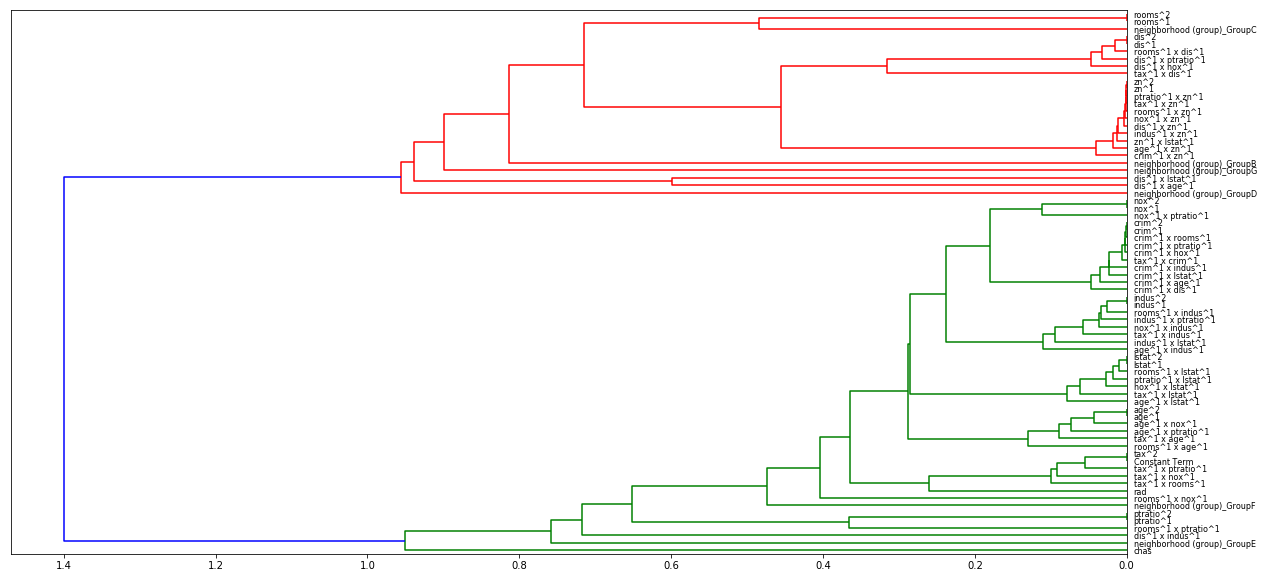

In [364]:
# highly correlated variables as you can see with all the polynomial features
# my first instinct is to remove highly correlated variables but that led to worst performance
# also I read that when doing polynomial features, you need to keep the x^1 and x^2 variables together

pear_corr(X_train_poly)


In [365]:
# feature selection withf_regression - does better with only 45 variables
# 3.38 RMSE, much better!

k_best = SelectKBest(f_regression)

num_cols = len(X_train_poly.columns)

k_params = ({'k_best__k':range(1,num_cols,1),
        'elnet__alpha': np.arange(0,0.3,0.05),
         'elnet__l1_ratio':np.arange(0,0.3,0.5),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('k_best',k_best),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
rs6 = GridSearchCV(k_pipe,param_grid=k_params,cv =rkfold, scoring= rmse_cv,error_score=0.0)
rs6.fit(X_train_poly,y_train)
print(rs6.best_score_)
print(rs6.best_estimator_)
print(rs6.score(X_test_poly,y_test))

-3.3804738560375296
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=49, score_func=<function f_regression at 0x0000024233AC17B8>)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False))])
-3.06514176501149


In [367]:
# select from model - doesnt do much better, actually worse. 

select = SelectFromModel(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.5,min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=True))

select_params = ({'select__threshold':[0.01,0.05,0.06,0.07,0.08,0.09,.1,.11,.12,.13,.14,.15,"mean"],
         'elnet__alpha': [0],
         'elnet__l1_ratio':[0],
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('select',select),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs3 = GridSearchCV(k_pipe,param_grid=select_params,cv = rkfold, scoring= rmse_cv,error_score=0.0)
gs3.fit(X_train_poly,y_train)
print(gs3.best_score_)
print(gs3.best_estimator_)
print(gs3.score(X_test_poly,y_test))

-4.131535719589391
Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_f...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])
-4.500012897071562


In [369]:
# will use selectKBest for 45 variables since random forest above did not perform well

k_best = SelectKBest(f_regression,k=49)
k_best.fit_transform(X_train_poly,y_train)

p_values = pd.DataFrame(
    {"column": X_train_poly.columns, "p_value": k_best.pvalues_}
).sort_values("p_value")
columns = p_values.head(49).column.unique().tolist()  # gather columns from k best =40
X_49 = X_train_poly[columns]
X_49.columns.tolist()

['ptratio^1 x lstat^1',
 'lstat^1',
 'tax^1 x lstat^1',
 'rooms^1 x lstat^1',
 'nox^1 x lstat^1',
 'age^1 x lstat^1',
 'indus^1 x lstat^1',
 'lstat^2',
 'nox^1 x ptratio^1',
 'neighborhood (group)_GroupF',
 'tax^1 x age^1',
 'crim^1 x lstat^1',
 'rooms^2',
 'rooms^1',
 'tax^1 x ptratio^1',
 'tax^1 x nox^1',
 'tax^1 x indus^1',
 'indus^1 x ptratio^1',
 'crim^1 x dis^1',
 'Constant Term',
 'nox^1 x indus^1',
 'age^1 x indus^1',
 'tax^2',
 'crim^1 x nox^1',
 'crim^1 x age^1',
 'age^1 x ptratio^1',
 'crim^1 x indus^1',
 'crim^1 x ptratio^1',
 'crim^1',
 'tax^1 x crim^1',
 'indus^1',
 'rad',
 'neighborhood (group)_GroupC',
 'crim^1 x rooms^1',
 'age^1 x nox^1',
 'ptratio^2',
 'nox^1',
 'ptratio^1',
 'nox^2',
 'indus^2',
 'age^2',
 'rooms^1 x indus^1',
 'age^1',
 'rooms^1 x dis^1',
 'tax^1 x rooms^1',
 'rooms^1 x zn^1',
 'nox^1 x zn^1',
 'age^1 x zn^1',
 'dis^1']

In [370]:
# get params for best elastic net
rs6.best_params_


{'elnet__alpha': 0.0,
 'elnet__l1_ratio': 0.0,
 'elnet__tol': 1e-05,
 'k_best__k': 49}

3.0349138014147363                    coefficients      values
13                      rooms^1  0.50800331
14            tax^1 x ptratio^1  0.50760929
26             crim^1 x indus^1  0.43637494
10                tax^1 x age^1  0.36642454
42                        age^1  0.27973387
1                       lstat^1  0.24090209
33             crim^1 x rooms^1  0.18530581
4               nox^1 x lstat^1  0.16874106
19                Constant Term  0.15659054
22                        tax^2  0.15249849
30                      indus^1  0.14056492
43              rooms^1 x dis^1  0.11996885
0           ptratio^1 x lstat^1  0.11446404
29               tax^1 x crim^1  0.11429456
36                        nox^1  0.11314745
7                       lstat^2  0.11237091
39                      indus^2  0.08600531
45               rooms^1 x zn^1  0.06879007
21              age^1 x indus^1  0.05851822
31                          rad  0.05260375
32  neighborhood (group)_GroupC  0.03245590
28           

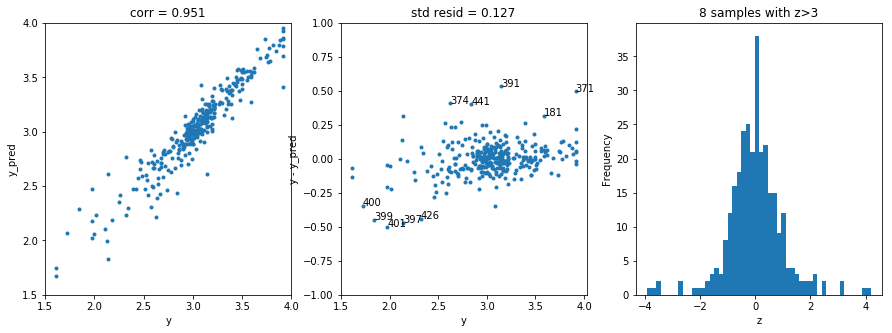

In [372]:
# initiate elastic net, look at coefficients and then at residuals

# scale 
sc = StandardScaler()
X_sc2 = sc.fit_transform(X_49)

elnet_final = ElasticNet(alpha=0,l1_ratio=0.0,tol=1e-05)
elnet_final.fit(X_sc2,y_train)
elnet_final.coef_
values = pd.DataFrame(elnet_final.coef_.reshape(-1,1),columns = ['values'])
names = pd.DataFrame(X_49.columns.tolist(),columns=['coefficients'])
coefficients = pd.concat([names,values],axis=1)
print(elnet_final.intercept_,coefficients.sort_values(by=['values'],ascending=False))

residual_plot(elnet_final,X_sc2,y_train)

In [374]:
# attempt to use boruta method to see if better performance
# this method takes the null distribution of adding duplicate columns and reshuffles
# then the importances are tested from the null distribution vs the actual variables (using random forest)
# those "Accepted" had higher test scores then the null distribution

from boruta import BorutaPy
rf = RandomForestRegressor(n_jobs=-1,max_depth=5)

feat_selector = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=1)
x = X_train_poly.values
y = y_train
feat_selector.fit(x,y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	16
Tentative: 	11
Rejected: 	46
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	11
Rejected: 	46
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	11
Rejected: 	46
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	11
Rejected: 	46
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	7
Rejected: 	49
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	7
Rejected: 	49
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	7
Rejected: 	49
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	7
Rejected: 	49
Iteration: 	16 / 100
Confirmed: 	18
Tentative: 	6
Re

BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=138, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x000002423B438A68>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x000002423B438A68>,
     two_step=True, verbose=2)

In [375]:
# shows results of boruta example
# those that are true are accepted

values = pd.DataFrame(feat_selector.ranking_,columns=['ranking'])
names = pd.DataFrame(X_train_poly.columns.tolist(),columns=['names'])
support = pd.DataFrame(feat_selector.support_,columns = ['support'])

df = pd.concat([values,names,support],axis=1)
df

,ranking,names,support
0,33,Constant Term,False
1,24,crim^1,False
2,1,rooms^1,True
3,7,dis^1,False
4,32,age^1,False
5,5,nox^1,False
6,38,indus^1,False
7,20,ptratio^1,False
8,51,zn^1,False
9,1,lstat^1,True


In [376]:
# filter to the confirmed values, 21 columns
df_true = df[df.support == True]
df_true
cols = df_true.names.unique().tolist()
cols

['rooms^1',
 'lstat^1',
 'tax^1 x nox^1',
 'tax^1 x lstat^1',
 'crim^1 x rooms^1',
 'crim^1 x dis^1',
 'crim^1 x nox^1',
 'crim^1 x lstat^1',
 'rooms^2',
 'rooms^1 x lstat^1',
 'dis^1 x nox^1',
 'dis^1 x indus^1',
 'dis^1 x lstat^1',
 'age^1 x ptratio^1',
 'age^1 x lstat^1',
 'nox^1 x ptratio^1',
 'nox^1 x lstat^1',
 'ptratio^1 x lstat^1',
 'lstat^2',
 'neighborhood (group)_GroupC',
 'neighborhood (group)_GroupF']

In [379]:
# best rmse was with 49 variables after doing polynomial terms
# if a simpler model is desired then can use the below since it only has 21 variables

sc = StandardScaler()
X_sc3 = sc.fit_transform(X_train_poly[cols])
X_sc4 = sc.fit_transform(X_test_poly[cols])

from sklearn.model_selection import cross_val_score
cross = cross_val_score(elnet_final,X_sc3,y_train,cv=rkfold,scoring=rmse_cv)
print(np.mean(cross))
cross_test = cross_val_score(elnet_final,X_sc4,y_test,cv=rkfold,scoring=rmse_cv)
print(np.mean(cross_test))


-4.552590905718319
-4.0275283681001355


9 outliers:
[166, 401, 416, 374, 391, 364, 369, 399, 400]
8 outliers:
[426, 441, 371, 401, 374, 397, 391, 399]


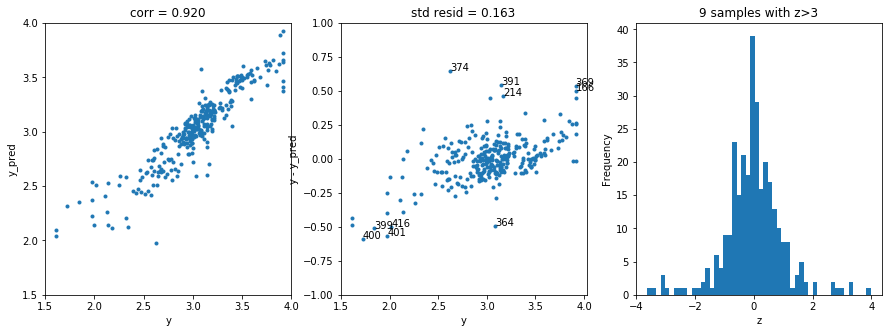

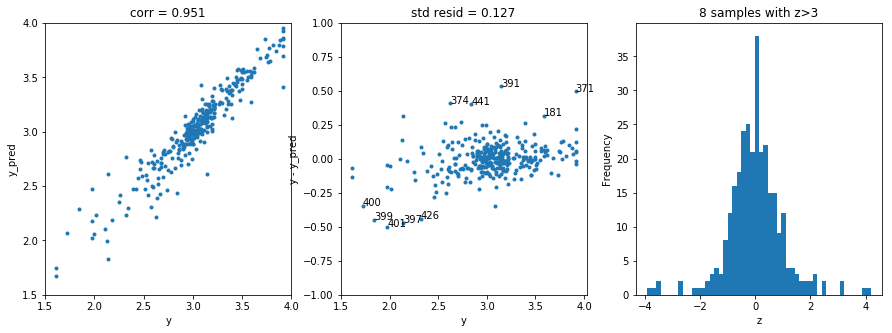

In [380]:
## showing residual plots of 2 best models
    
## residual plots with 11 best variables (2nd best)

residual_plot(elnet_first,X_sc1,y_train)

## residual plots with polynomial features, 49 total ( best model)

residual_plot(elnet_final,X_sc2,y_train)